In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

prng = np.random.RandomState(20250310)

%precision 3
pd.set_option('display.precision', 3)

# Bias-variance decomposition

$$
Y = f(X) + \varepsilon
$$

Our goal is to find a prediction function based on some data ${(X_i, Y_i), ..., (X_n, Y_n)}$ that approximates the true function well.

We can decompose the prediction error of our model into the sum of the bias (squared) and the variance of the model (plus the irreducible error).

*Question:* Why is it called "irreducible error"?

<details>
<summary>Answer</summary>

No matter how perfect our model becomes, we cannot reduce prediction error to zero. This remaining 'irreducible error' exists because real-world data contains inherent randomness and unmeasured variables that influence outcomes. These unpredictable elements represent the fundamental noise in any system that no model can capture.

</details>

To prove the statement above, let's decompose the expected prediction error:

$$
\begin{align*}
    E\left[\left(Y - \hat{f}(X)\right)^2\right] &= E\left[\left(f(X) + \varepsilon - \hat{f}(X)\right)^2\right] \\
        &= E\left[\left(f(X) - \hat{f}(X)\right)^2\right] + 2E\left[\varepsilon(f(X) - \hat{f}(X))\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - \hat{f}(X)\right)^2\right] + 2\underbrace{E[\varepsilon]}_{=0}E\left[f(X) - \hat{f}(X)\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - E[\hat{f}(X)] + E[\hat{f}(X)] - \hat{f}(X)\right)^2\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - E[\hat{f}(X)]\right)^2\right] + 2\underbrace{E\left[\left(f(X) - E[\hat{f}(X)]\right)\left(E[\hat{f}(X)] - \hat{f}(X)\right)\right]}_{=f(x)\left(E[\hat{f}(X)] - E[\hat{f}(X)]\right) - E[\hat{f}(X)]^2 + E[\hat{f}(X)]^2 = 0} + E\left[\left(E[\hat{f}(X)] - \hat{f}(X)\right)^2\right] + E\left[\varepsilon^2\right] \\
    
        &= \left(\underbrace{f(X) - E[\hat{f}(X)]}_{\text{Bias}} \right)^2 + \underbrace{E\left[\left(E[\hat{f}(X)] - \hat{f}(X)\right)^2\right]}_{\text{Variance}} + \underbrace{E\left[\varepsilon^2\right]}_{\text{Irreducible error}}
\end{align*}
$$

Thus, MSE = Squared Bias + Variance + Irreducible error.

# Illustrating bias-variance trade-off: Linear vs quadratic model

## Our problem

Let's start with a simple linear model:

$$
Y = f(X) + \varepsilon = \beta_1 X^2 + \beta_2 X + \varepsilon
$$

The true model is:

$$
f(X) = X^2 - 1.5 X
$$

In [169]:
def trueModel(x):
    y = x**2 - 1.5*x
    return y

def generateData(prng, sample_size):
    x = prng.uniform(0, 1, size=sample_size)
    y_true = trueModel(x)
    y = y_true + prng.normal(0, 1, size=sample_size)

    feature_df = pd.DataFrame({'x': x})
    return feature_df, y

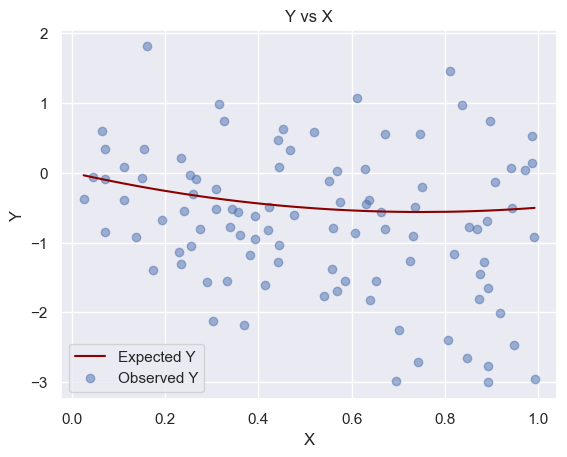

In [170]:
# Plot
features, y = generateData(prng, sample_size=100)

plt.plot(features['x'].sort_values(), trueModel(features['x'].sort_values()), label="Expected Y", color='darkred')
plt.scatter(features['x'], y, label="Observed Y", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Y vs X")
plt.legend()
plt.show()

In [171]:
# Evaluate the model's performance at a single point: X=0.5 (y = -0.5)
test_data = pd.DataFrame({'x': [0.5]})
trueModel(test_data['x'])[0]


-0.500

## Estimate two models

### Technical detour: pandas Dataframe vs Series

If `data` is a pandas Dataframe, then `data['x']` is a pandas Series. Pandas Series are like numpy arrays but with additional functionality.
If you would like to pass a Dataframe with a single column, you can use the `data[['x']]` syntax. (Think of it as the standard way of selecting columns from a Dataframe that you would do with  `data[list_of_columns]` syntax, e.g. `data[['x', 'y']]`. For a single column, this just collapses to `data[['x']]`.)
If you would like to get a scalar value, you should index it again. To get the first element (which could be the only element), you can use `data['x'][0]`.

Be careful with the different types of objects you get back. Some methods expect pandas Dataframes, others might expect scalars, or numpy arrays.

In [172]:

simple_model = Pipeline([("lm", LinearRegression())])
simple_model.fit(features, y)

simple_model.predict(test_data)

array([-0.678])

In [173]:
squared_model = Pipeline([
    ("add-quadratic-term", PolynomialFeatures(degree=2, include_bias=False)),
    ('lm', LinearRegression())
])
squared_model.fit(features, y)

squared_model.predict(test_data)

array([-0.746])

## Monte Carlo simulation

In [174]:
# Set the number of Monte Carlo iterations and sample size
num_iterations = 1000
sample_size = 100

# Initialize arrays to store the results
predictions = np.empty((num_iterations, 2))

# Perform the Monte Carlo simulation
for i in range(num_iterations):

    features, y = generateData(prng, sample_size=sample_size)
    
    simple_fit = simple_model.fit(features, y)
    squared_fit = squared_model.fit(features, y)
    
    predictions[i, 0] = simple_fit.predict(test_data)[0]  # _[0] is needed to extract the first (and only) element of the prediction from the array
    predictions[i, 1] = squared_fit.predict(test_data)[0]

In [175]:
# Summarize the results
pd.DataFrame({
    'model': ['simple', 'squared'],
    'x0': test_data['x'][0],
    'bias': np.mean(predictions - trueModel(test_data['x'])[0], axis=0),
    'variance': np.var(predictions, axis=0),
    'mse': np.mean(np.square(predictions - trueModel(test_data['x'])[0]), axis=0)
})


,model,x0,bias,variance,mse
0,simple,0.5,0.080,0.010,0.017
1,squared,0.5,-0.003,0.024,0.024


Note that on average the simpler model gave better predictions than the *true* model!

*Question:* Which of the parameters (`num_iterations`, `sample_size`) should be changed to alter this result?

<details>
<summary>Answer</summary>

The `sample_size` parameter along with the implicit parameter of the variance of the noise term $\varepsilon$ together determine the signal-to-noise ratio. With larger samples, the true patterns become more distinguishable from random noise, which enables the complex model to benefit more from its accurate representation of the true relationship than what it loses on its higher variance. Try estimate the models with `sample_size=500` and compare the results with the ones above.

</details>

##  Gather some intuition for bias-variance trade-off

Text(0.5, 1.0, 'Quadratic (n=1000)')

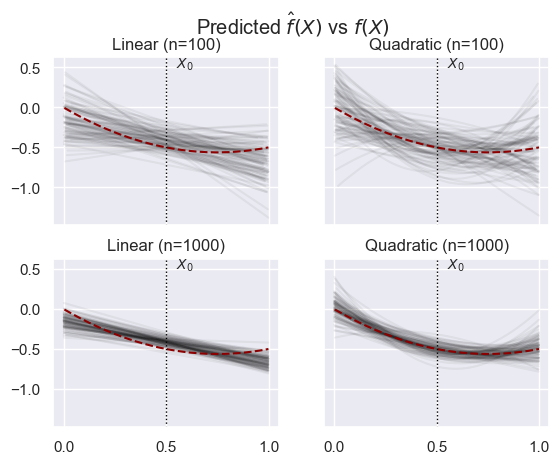

In [176]:
# Plot predictions
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of Monte Carlo iterations and sample size
num_iterations = 100
sample_sizes = [100, 500]

# Initialize chart
fig, (axs) = plt.subplots(2, 2, sharey=True, sharex=True)

beta1_predictions = np.empty((num_iterations, 2, 2))

# Perform the Monte Carlo simulation
for i in range(num_iterations):

    for ids, s in enumerate(sample_sizes):
        features, y = generateData(prng, sample_size=s)

        simple_model = simple_model.fit(features, y)
        squared_model = squared_model.fit(features, y)

        simple_prediction = simple_model.predict(features.sort_values(by='x'))  # we need to sort them for the plot
        squared_prediction = squared_model.predict(features.sort_values(by='x'))
        
        beta1_predictions[i, ids, 0] = simple_model['lm'].coef_[0]
        beta1_predictions[i, ids, 1] = squared_model['lm'].coef_[0]

        axs[ids, 0].plot(features['x'].sort_values(), simple_prediction, color='black', alpha=0.05)
        axs[ids, 1].plot(features['x'].sort_values(), squared_prediction, color='black', alpha=0.05)

for ax in axs.flat:
    ax.plot(features['x'].sort_values(), trueModel(features['x'].sort_values()), color='darkred', linestyle='dashed')
    ax.axvline(x=0.5, ymin=0, ymax=1, linestyle="dotted", color="black", linewidth=1)
    ax.annotate(r"$X_0$", xy=(0.5, ax.get_ylim()[1]), xytext=(0.55, 0.5), fontsize=10)
    
fig.suptitle(r"Predicted $\hat{f}(X)$ vs $f(X)$")
axs[0, 0].set_title("Linear (n=100)")
axs[0, 1].set_title("Quadratic (n=100)")
axs[1, 0].set_title("Linear (n=1000)")
axs[1, 1].set_title("Quadratic (n=1000)")




Text(0.5, 1.0, 'Quadratic (n=1000)')

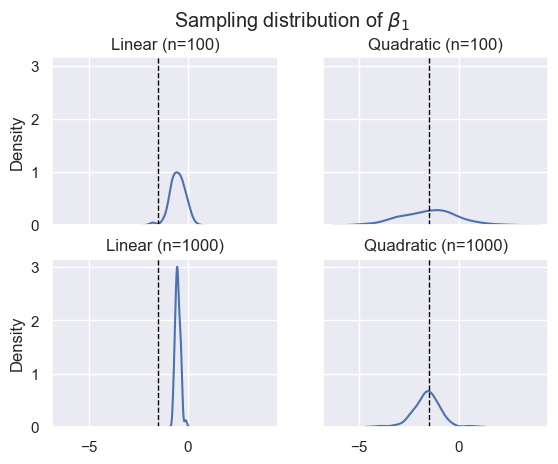

In [177]:
fig, (axs) = plt.subplots(2, 2, sharey=True, sharex=True)
for ax1 in range(2):
    for ax2 in range (2):
        s = sns.kdeplot(beta1_predictions[:, ax1, ax2], ax=axs[ax1, ax2])
        s.axvline(x=-1.5, ymin=0, ymax=1, linestyle="dashed", color="black", linewidth=1)

fig.suptitle(r"Sampling distribution of $\beta_1$")
axs[0, 0].set_title("Linear (n=100)")
axs[0, 1].set_title("Quadratic (n=100)")
axs[1, 0].set_title("Linear (n=1000)")
axs[1, 1].set_title("Quadratic (n=1000)")

![Bias-Variance Tradeoff](bias-variance-tradeoff.jpeg)
